# Trilateration accuracy based on WSN
## Getting sufficient imports

In [21]:
from math import sqrt
import xlrd
import random
from pandas import Series
from matplotlib import pyplot

### Setting points

In [22]:
class point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

### Estimating anchors

In [23]:
class anchor(object):
    def __init__(self, x, y, xest, yest, power):
        self.x = x
        self.y = y
        self.xest = xest
        self.yest = yest
        self.power = power

### Determining Eucledian distance

In [24]:
def distanceBetweenPoints(p1, p2):
    return sqrt(((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) * 1.0)

### Remove points that cannot be reached by 3 neighbours

In [25]:
def deletePointsFromList(pointList, pointsToDelete):
    for i in range(len(pointsToDelete)):
        for j in range(len(pointList)):
            if pointList[j].x == pointsToDelete[i].x and pointList[j].y == pointsToDelete[i].y:
                pointList.pop(j)
                break
    return pointList

### Remove points that are out of range of other neighbours

In [26]:
def cleanListFromPointsThatCannotBeEstimated(pointList, Range, numberOfNeighbours):
    pointsToDelete = list()
    for indeks in range(len(pointList)):
        currentPoint = pointList[indeks]
        distanceList = list()
        for indeks2 in range(len(pointList)):
            distanceList.append(distanceBetweenPoints(currentPoint, pointList[indeks2]))

        distanceList.sort()

        for neigbour in range(numberOfNeighbours):
            if (distanceList[neigbour + 1] > Range):
                pointsToDelete.append(currentPoint)
                break

    if (len(pointsToDelete) == 0):
        return pointList
    else:
        pointList = deletePointsFromList(pointList, pointsToDelete)
        return cleanListFromPointsThatCannotBeEstimated(pointList, Range, numberOfNeighbours)

### We are defining the base of trilateration using three anchors for determening an unknown node

In [27]:
def trilateration(anchors: dict):

    p1, p2, p3 = anchors.keys()
    r1, r2, r3 = anchors.values()
    A = p1[0] - p2[0]
    B = p1[1] - p2[1]
    D = p1[0] - p3[0]
    E = p1[1] - p3[1]

    T = (r1 ** 2 - p1[0] ** 2 - p1[1] ** 2)
    C = (r2 ** 2 - p2[0] ** 2 - p2[1] ** 2) - T
    F = (r3 ** 2 - p3[0] ** 2 - p3[1] ** 2) - T

    Mx = (C * E - B * F) / 2
    My = (A * F - D * C) / 2
    M = A * E - D * B

    x = Mx / M
    y = My / M

    return x, y

### Instead of generating the points directly, we are reading them from an already made xlsx file made with xlsxwriter

In [28]:
def readFile(fileName):
    # open workbook
    xValues = list()
    yValues = list()

    file = xlrd.open_workbook(fileName)

    # get worksheet

    worksheet = file.sheet_by_index(0)

    # get number of rows

    numRows = worksheet.nrows

    # read data row by row

    for row in range(numRows):
        xValues.append(worksheet.row_values(row)[0])
        yValues.append(worksheet.row_values(row)[1])

    points = list()
    for indeks in range(len(xValues)):
        points.append(point(xValues[indeks], yValues[indeks]))

    return points

## Main code block where we use these predefined methods
### This is where we actually are creating the anchor points based on percentage of occupation
### By using the trilateration method we are determening the unknown nodes which after estimation has passed without any error or the point is not removed i becomes another anchor point from which we continue the estimation of the other unknown nodes

In [31]:
percentOfErrors=list()
setInformation=list()
for set in range(0,20):
    diffValues=list()
    errorDiffValuesHev0=list()
    errorDiffValuesHev1=list()
    for er in range(5,30,5):
        n=100
        a = 25
        numberOfNeighbours = 3
        L = 100  # from values in excel from 1 to 100
        numberOfNodes = 100  # from values in excel
        R = 25  # Range of signal for each node

        #set = 0  # use this to iterate over files
        fileName = "values/values" + str(set) + ".xlsx"
        points = readFile(fileName)

        # clean lists from points that cannot be estimated!!! They do not have 3 neighbours in given Range
        cleanedPointList = cleanListFromPointsThatCannotBeEstimated(points, R, numberOfNeighbours)

        anchorPointList = list()
        for anchorIndex in range(a):
            current = cleanedPointList[anchorIndex]
            anchorPointList.append(anchor(current.x, current.y, current.x, current.y, 0))

        # delete Anchor nodes from list
        cleanedPointList = deletePointsFromList(cleanedPointList, cleanedPointList[:a])

        # copy the records for the second heuristic
        cleanedPointListHev1 = cleanedPointList[:]
        anchorPointListHev1 = anchorPointList[:]

        # First make calculations for the first Heuristic
        while (len(cleanedPointList) > 0):
            oldLen = len(cleanedPointList)
            for pointIndex in range(len(cleanedPointList)):
                distanceList = list()
                for anchorIndex in range(len(anchorPointList)):
                    distance = distanceBetweenPoints(
                        point(anchorPointList[anchorIndex].xest, anchorPointList[anchorIndex].yest),
                        cleanedPointList[pointIndex])
                    if distance <= R:
                        distanceList.append(distance)


                distanceList.sort()


                if len(distanceList) >= 3 and distanceList[0] <= R and distanceList[1] <= R and distanceList[2] <= R:
                    anchorForThisPoint = list()
                    distanceIndex = 0
                    for i in range(len(anchorPointList)):
                        if distanceList[distanceIndex] >= distanceBetweenPoints(
                                point(anchorPointList[i].xest, anchorPointList[i].yest),
                                cleanedPointList[pointIndex]) - er and \
                                distanceList[distanceIndex] <= distanceBetweenPoints(
                            point(anchorPointList[i].xest, anchorPointList[i].yest), cleanedPointList[pointIndex]) + er:
                            anchorForThisPoint.append(anchorPointList[i])
                            distanceIndex = distanceIndex + 1
                        if distanceIndex == 3:
                            break
                    if len(anchorForThisPoint)>=3:
                        my_dict = dict()
                        percentMistake=random.randint(0,er)
                        sign=1
                        if random.randint(0,1)==0:
                            sign=-1
                        my_dict[(anchorForThisPoint[0].xest, anchorForThisPoint[0].yest)] = distanceBetweenPoints(point(anchorForThisPoint[0].xest, anchorForThisPoint[0].yest), cleanedPointList[pointIndex])+(distanceBetweenPoints(point(anchorForThisPoint[0].xest, anchorForThisPoint[0].yest), cleanedPointList[pointIndex])/100)*percentMistake*sign
                        percentMistake = random.randint(0, er)
                        sign = 1
                        if random.randint(0, 1) == 0:
                            sign = -1
                        my_dict[(anchorForThisPoint[1].xest, anchorForThisPoint[1].yest)] = distanceBetweenPoints(point(anchorForThisPoint[1].xest, anchorForThisPoint[1].yest), cleanedPointList[pointIndex])+(distanceBetweenPoints(point(anchorForThisPoint[1].xest, anchorForThisPoint[1].yest), cleanedPointList[pointIndex])/100)*percentMistake*sign
                        percentMistake = random.randint(0, er)
                        sign = 1
                        if random.randint(0, 1) == 0:
                            sign = -1
                        my_dict[(anchorForThisPoint[2].xest, anchorForThisPoint[2].yest)] = distanceBetweenPoints(point(anchorForThisPoint[2].xest, anchorForThisPoint[2].yest), cleanedPointList[pointIndex])+(distanceBetweenPoints(point(anchorForThisPoint[2].xest, anchorForThisPoint[2].yest), cleanedPointList[pointIndex])/100)*sign*percentMistake

                        thereWasAnError = 0
                        try:
                            xest, yest = trilateration(my_dict)
                        except:
                            thereWasAnError = 1
                        if thereWasAnError == 0:
                            power = anchorForThisPoint[0].power + anchorForThisPoint[1].power + anchorForThisPoint[
                                2].power + 1
                            anchorPointList.append(
                                anchor(cleanedPointList[pointIndex].x, cleanedPointList[pointIndex].y, xest, yest,
                                       power))
                            pointToDelete = point(anchorPointList[len(anchorPointList) - 1].x,
                                                  anchorPointList[len(anchorPointList) - 1].y)
                            cleanedPointList = deletePointsFromList(cleanedPointList, [pointToDelete])

                            break
            if oldLen == len(cleanedPointList):
                break

        sumErrors=0
        for k in range(len(anchorPointList)):
            sumErrors=sumErrors+sqrt((anchorPointList[k].x-anchorPointList[k].xest)**2+(anchorPointList[k].y-anchorPointList[k].yest)**2)
        ER=(sumErrors/(R*(n-a)))*100
        errorDiffValuesHev0.append(ER)

        anchorPointList = anchorPointListHev1[:]
        cleanedPointList = cleanedPointListHev1[:]

        while (len(cleanedPointList) > 0):
            oldLen = len(cleanedPointList)
            for pointIndex in range(len(cleanedPointList)):

                distanceList = list()
                for anchorIndex in range(len(anchorPointList)):
                    distance = distanceBetweenPoints(
                        point(anchorPointList[anchorIndex].xest, anchorPointList[anchorIndex].yest),
                        cleanedPointList[pointIndex])
                    if distance <= R:
                        distanceList.append((distance, anchorPointList[anchorIndex].power))


                for i in range(len(distanceList) - 1):
                    for j in range(i + 1, len(distanceList)):
                        if (distanceList[i][1] > distanceList[j][1]):
                            temp = distanceList[i]
                            distanceList[i] = distanceList[j]
                            distanceList[j] = temp

                if len(distanceList) >= 3 and distanceList[0][0] <= R and distanceList[1][0] <= R and distanceList[2][
                    0] <= R:
                    anchorForThisPoint = list()
                    distanceIndex = 0
                    for i in range(len(anchorPointList)):
                        if (distanceList[distanceIndex][0] >= distanceBetweenPoints(
                                point(anchorPointList[i].xest, anchorPointList[i].yest),
                                cleanedPointList[pointIndex])-er and distanceList[distanceIndex][0]<=distanceBetweenPoints(
                                point(anchorPointList[i].xest, anchorPointList[i].yest),
                                cleanedPointList[pointIndex])+er) and distanceList[distanceIndex][1]==anchorPointList[i].power:
                            anchorForThisPoint.append(anchorPointList[i])
                            distanceIndex = distanceIndex + 1
                        if distanceIndex == 3:
                            break

                    if len(anchorForThisPoint)>=3:
                        my_dict = dict()
                        percentMistake = random.randint(0, er)
                        sign = 1
                        if random.randint(0, 1) == 0:
                            sign = -1
                        my_dict[(anchorForThisPoint[0].xest, anchorForThisPoint[0].yest)] = distanceBetweenPoints(
                            point(anchorForThisPoint[0].xest, anchorForThisPoint[0].yest),
                            cleanedPointList[pointIndex]) + (distanceBetweenPoints(
                            point(anchorForThisPoint[0].xest, anchorForThisPoint[0].yest),
                            cleanedPointList[pointIndex]) / 100) * percentMistake * sign
                        percentMistake = random.randint(0, er)
                        sign = 1
                        if random.randint(0, 1) == 0:
                            sign = -1
                        my_dict[(anchorForThisPoint[1].xest, anchorForThisPoint[1].yest)] = distanceBetweenPoints(
                            point(anchorForThisPoint[1].xest, anchorForThisPoint[1].yest),
                            cleanedPointList[pointIndex]) + (distanceBetweenPoints(
                            point(anchorForThisPoint[1].xest, anchorForThisPoint[1].yest),
                            cleanedPointList[pointIndex]) / 100) * percentMistake * sign
                        percentMistake = random.randint(0, er)
                        sign = 1
                        if random.randint(0, 1) == 0:
                            sign = -1
                        my_dict[(anchorForThisPoint[2].xest, anchorForThisPoint[2].yest)] = distanceBetweenPoints(
                            point(anchorForThisPoint[2].xest, anchorForThisPoint[2].yest),
                            cleanedPointList[pointIndex]) + (distanceBetweenPoints(
                            point(anchorForThisPoint[2].xest, anchorForThisPoint[2].yest),
                            cleanedPointList[pointIndex]) / 100) * sign * percentMistake

                        thereWasAnError = 0
                        try:
                            xest, yest = trilateration(my_dict)
                        except:
                            thereWasAnError = 1
                        if thereWasAnError == 0:
                            power = anchorForThisPoint[0].power + anchorForThisPoint[1].power + anchorForThisPoint[
                                2].power + 1
                            anchorPointList.append(
                                anchor(cleanedPointList[pointIndex].x, cleanedPointList[pointIndex].y, xest, yest,
                                       power))
                            pointToDelete = point(anchorPointList[len(anchorPointList) - 1].x,
                                                  anchorPointList[len(anchorPointList) - 1].y)
                            cleanedPointList = deletePointsFromList(cleanedPointList, [pointToDelete])

                            break

            if oldLen == len(cleanedPointList):
                break

        sumErrors = 0
        for k in range(len(anchorPointList)):
            sumErrors = sumErrors + sqrt((anchorPointList[k].x - anchorPointList[k].xest) ** 2 + (
                        anchorPointList[k].y - anchorPointList[k].yest) ** 2)
        ER = (sumErrors / (R * (n - a))) * 100
        errorDiffValuesHev1.append(ER)
        diffValues.append(er)
    setInformation.append((errorDiffValuesHev0,errorDiffValuesHev1,diffValues))

### Plotting the actual two heuristics. The first Heuristic being that we are estimating the point by using the three points from the 3 circles that are closes together. The second Heuristic determining by the strength of the signal between 3 points

set:
[([5.681394775288028, 26.312962823861014, 31.20502775824388, 129.9976260082526, 115.25891486630779], [15.741413420280248, 21.940466768626614, 31.057592263503373, 58.27362990383106, 80.54706745002119], [5, 10, 15, 20, 25]), ([5.068089286093469, 14.525645961880896, 33.232503472426046, 62.44768875993755, 55.73631828083996], [18.32785392943547, 46.52884189323358, 107.67435624992888, 118.37473321638893, 113.10482258727268], [5, 10, 15, 20, 25]), ([10.470503629568132, 18.322670470209502, 21.76415481964952, 43.671520526944654, 49.83471874261703], [10.888846850574186, 104.89088694532597, 29.962734570482287, 66.28514019186706, 207.42821484731476], [5, 10, 15, 20, 25]), ([12.655384755020465, 21.14824378852448, 67.71004347566726, 144.52094888791174, 249.658986096475], [20.106478556214906, 36.29161837974739, 115.796102757465, 232.20440428806745, 264.1455339891852], [5, 10, 15, 20, 25]), ([10.3426040987422, 31.786833255663687, 25.407418905141103, 38.08463915668878, 54.186464296143086], [11.392

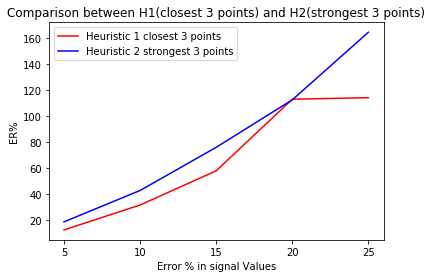

In [32]:
averagePercentErrorOfHeuristic0=list()
averagePercentErrorOfHeuristic1=list()
sumErrorOfHeuristic0=[0,0,0,0,0]
sumErrorOfHeuristic1=[0,0,0,0,0]
for i in range(len(setInformation)):
    print("set:")
    print(setInformation)
    for j in range(len(setInformation[i][0])):
        sumErrorOfHeuristic0[j]=sumErrorOfHeuristic0[j]+setInformation[i][0][j]
    for j in range(len(setInformation[i][1])):
        sumErrorOfHeuristic1[j] = sumErrorOfHeuristic1[j] + setInformation[i][1][j]

for i in range(len(sumErrorOfHeuristic0)):
    averagePercentErrorOfHeuristic0.append(sumErrorOfHeuristic0[i]/len(setInformation))
for i in range(len(sumErrorOfHeuristic1)):
    averagePercentErrorOfHeuristic1.append(sumErrorOfHeuristic1[i]/len(setInformation))
    print(sumErrorOfHeuristic1[i])
    print(sumErrorOfHeuristic1[i]/len(setInformation))

print(averagePercentErrorOfHeuristic0)
print(averagePercentErrorOfHeuristic1)

pyplot.subplot(xlabel='Error % in signal Values', ylabel='ER%',title='Comparison between H1(closest 3 points) and H2(strongest 3 points)')
pyplot.plot(averagePercentErrorOfHeuristic0,color='red', label='Heuristic 1 closest 3 points')
pyplot.plot(averagePercentErrorOfHeuristic1,color='blue', label='Heuristic 2 strongest 3 points')
locs, labels = pyplot.xticks([0,1,2,3,4], setInformation[0][2])
pyplot.setp(labels, 'rotation', 'horizontal')
pyplot.legend(loc='best')

pyplot.show()